# Amazon Fine Food Reviews

#### Context
    This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

#### Dataset Description
    The dataset is included with 2 formats - Reviews.csv and database.sqlite(which contains Reviews table)
       Overall Description:
           Data includes:
            - Reviews from Oct 1999 - Oct 2012
            - 568,454 reviews
            - 256,059 users
            - 74,258 products
            - 260 users with > 50 reviews
            
        High level Description: Attributes Information
            - Id - Row Id
            - ProductId - Unique identifier for the product
            - UserId - Unqiue identifier for the user
            - ProfileName - Profile name of the user
            - HelpfulnessNumerator - Number of users who found the review helpful
            - HelpfulnessDenominator - Number of users who indicated whether they found the review helpful or not
            - Score - Rating between 1 and 5
            - Time - Timestamp for the review
            - Summary - Brief summary of the review
            - Text - Text of the review
    

#### Objective
    The main objective is - Given a review, determine whether that review is Positive or Negative.
    The review can be classified as positive if the Rating/Score is more than 3 and similarly, negative if the Rating/Score is less than 3. Though a review with Rating/Score as 3 is considered neutral and is hence ignored in our analysis.
    Note - This is a very approximate and proxy method of determining the polarity of the reviews as Positive/Negative/Neutral.

## Importing the libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
import string
import sqlite3
import nltk
import re
import time
from nltk.corpus import stopwords

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec

## Loading the data

In [2]:
# Create a connection
conn = sqlite3.connect('../../../../Datasets/amazon-reviews-dataset/database.sqlite')

# Read from the sqlite3 database using the connection and save it in dataframe using pandas library
# Note - We will only fetch those reviews where the score is not equal to 3 (Assumption - Score of 3 is considered as Neutral)
data_df = pd.read_sql_query('SELECT * FROM REVIEWS WHERE SCORE != 3', conn)

# Printing out the shape of the dataframe
df_shape_tup = data_df.shape
print("Number of Reviews - {} and Features/Attributes - {}".format(df_shape_tup[0],df_shape_tup[1]))

Number of Reviews - 525814 and Features/Attributes - 10


In [3]:
# Printing out the first 2 rows of data_db dataframe
data_df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [4]:
# Printing out the higher level statistics of the dataset
data_df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,525814.000000,525814.000000,525814.000000,525814.000000,5.258140e+05
mean,284599.060038,1.747293,2.209544,4.279148,1.295943e+09
std,163984.038077,7.575819,8.195329,1.316725,4.828129e+07
min,1.000000,0.000000,0.000000,1.000000,9.393408e+08
25%,142730.250000,0.000000,0.000000,4.000000,1.270598e+09
50%,284989.500000,0.000000,1.000000,5.000000,1.310861e+09
75%,426446.750000,2.000000,2.000000,5.000000,1.332634e+09
max,568454.000000,866.000000,878.000000,5.000000,1.351210e+09


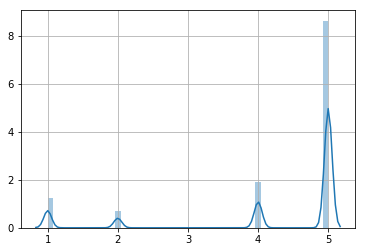

In [3]:
plt.close()
sns.distplot(data_df['Score'].values)
plt.grid()
plt.show()

In [5]:
# Printing out the higher level information of each feature
print(data_df.info())
print("\nThe Unique values in the class attribute column are : {}".format(data_df['Score'].unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525814 entries, 0 to 525813
Data columns (total 10 columns):
Id                        525814 non-null int64
ProductId                 525814 non-null object
UserId                    525814 non-null object
ProfileName               525814 non-null object
HelpfulnessNumerator      525814 non-null int64
HelpfulnessDenominator    525814 non-null int64
Score                     525814 non-null int64
Time                      525814 non-null int64
Summary                   525814 non-null object
Text                      525814 non-null object
dtypes: int64(5), object(5)
memory usage: 40.1+ MB
None

The Unique values in the class attribute column are : [5 1 4 2]


**_Observation:_**
1. The dataset contains 525814 rows with 10 attributes/features.
2. The dataset doesnot contain any null/NA values in features.
3. For our analysis, the score is used for classification whether the review 'Text' is positive or negative. Since the column/attribute/feature is Numeric. It must be converted to categorical datatype by using some if else logic.
4. The Score can be mapped as Positive if the value is greater than 3 and Negative if the value is less than 3.

## Data Preprocessing, Data DeDuplication, Stemming, Removing Stopwords

In [6]:
# Data Preprocessing
# 1. Score mapping - The Score which is classification attribute needs to be mapped to Positive and Negative inorder
#                    for better classfication visually.

def score_mapping(score):
    if score > 3:
        return "Positive"
    else:
        return "Negative"
    

data_df['Score'] = data_df['Score'].map(score_mapping)
print(data_df['Score'].value_counts())
print("\n" + str(data_df['Score'].value_counts(normalize=True)))
print("\n" + str(data_df.isnull().any()))

Positive    443777
Negative     82037
Name: Score, dtype: int64

Positive    0.843981
Negative    0.156019
Name: Score, dtype: float64

Id                        False
ProductId                 False
UserId                    False
ProfileName               False
HelpfulnessNumerator      False
HelpfulnessDenominator    False
Score                     False
Time                      False
Summary                   False
Text                      False
dtype: bool


**_Observation:_**
1. As per the analysis on class attribute "Score", we find that the dataset is quite imbalanced with 84% values as positive and 16% values as negative.
2. Also there are no null values in any of the columns/attributes/features.

In [7]:
# Data Preprocessing
# 2. Helpfulness Numerator must be less than or equal to Helpfulness Denominator
previous_n = data_df.shape[0]
data_df = data_df[data_df['HelpfulnessNumerator'] <= data_df["HelpfulnessDenominator"]]
print("After Data processing Step 2: Shape - " + str(data_df.shape))
print("{} reviews removed".format(previous_n-data_df.shape[0]))

After Data processing Step 2: Shape - (525812, 10)
2 reviews removed


In [8]:
# Data Preprocessing
# 3. Removing duplicate entries
previous_n = data_df.shape[0]
data_df.sort_values(by='ProductId', axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
data_df.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=True)
print("After Data processing Step 2: Shape - " + str(data_df.shape))
print("{} reviews removed".format(previous_n-data_df.shape[0]))

After Data processing Step 2: Shape - (364171, 10)
161641 reviews removed


In [9]:
# Data Preprocessing
# 4. Removing HTML tags,punctuations,stopwords and stemming
def CleanHTML(sentence):
    cleanedText = re.sub('<.*?>', '', sentence)
    return cleanedText

def CleanPunc(sentence):
    cleanedText = re.sub(r'[?|!|@|#|^|&|*|_|-|"|\'|:|;|+]', r'', sentence)
    cleanedText = re.sub(r'[.|,|)|(|\|/]', r' ', cleanedText)
    return cleanedText

def cleanText(input):
    stop = set(stopwords.words('english')) #set of stopwords
    sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
    cleanedText_df = pd.DataFrame()
    final_str = []
    str = ''
    for sentence in tqdm(input.values):
        filtered_sentence = []
        for words in CleanHTML(sentence).split():
            for cleanedText in CleanPunc(words).split():
                if(len(cleanedText) > 2 & cleanedText.isalpha()):
                    if(cleanedText.lower() not in stop):
                        s = (sno.stem(cleanedText.lower())).encode('UTF-8')
                        filtered_sentence.append(s)
        str = b' '.join(filtered_sentence)
        final_str.append(str)
    cleanedText_df['CleanedText'] = final_str
    cleanedText_df['CleanedText'] = cleanedText_df['CleanedText'].str.decode('UTF-8')
    return cleanedText_df['CleanedText'].values


scores_df = data_df['Score'].values
final_df = pd.DataFrame(data_df['Text'], columns=['Text'])
final_df['Score'] = scores_df

del data_df
del scores_df
final_df = final_df.sample(n=15000, random_state=0)
final_df['CleanedText'] = cleanText(final_df['Text'])

final_df.shape

100%|██████████| 15000/15000 [00:13<00:00, 1142.28it/s]


(15000, 3)

Starting BOW methods with shape : (15000, 3)
Starting BoW UniGram
The Shape of BoW Model Uni-Gram : (15000, 19849)
Converting the csr_matrix to ndarray
Standardizing the data
Starting the TSNE Model
TSNE Model completed for Bow-UniGram in 10120.856751441956


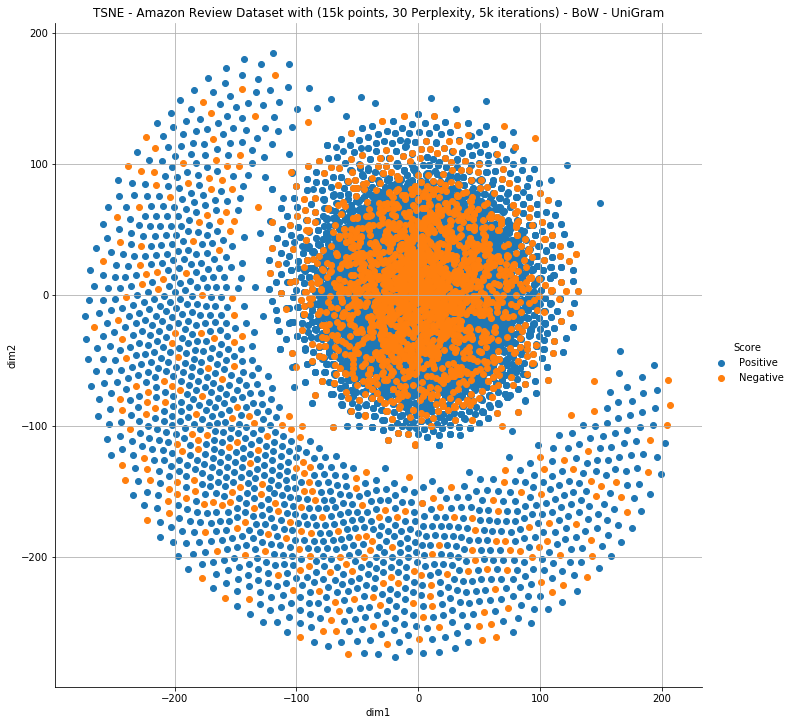

In [10]:
# BOW
def bowUniGramMethod(df):
    print("Starting BOW methods with shape : " + str(df.shape))
    # BOW Uni-Gram
    scores_df = df['Score']
    start_time = time.time()
    print('Starting BoW UniGram')
    final_text = CountVectorizer().fit_transform(df['CleanedText'].values)
    print("The Shape of BoW Model Uni-Gram : " + str(final_text.shape))

    print('Converting the csr_matrix to ndarray')
    final_text = final_text.toarray().astype(float)
    print('Standardizing the data')
    final_text = StandardScaler().fit_transform(final_text)
    print('Starting the TSNE Model')
    tsne_data = TSNE(perplexity=30, n_iter=5000, n_components=2, random_state=0).fit_transform(final_text)
    final_df = pd.DataFrame(tsne_data, columns=['dim1', 'dim2'])
    final_df['Score'] = scores_df.values
    print('TSNE Model completed for Bow-UniGram in ' + str(time.time() - start_time))
    
    plt.close()
    sns.FacetGrid(data=final_df, hue='Score', height=10).map(plt.scatter, "dim1", "dim2").add_legend()
    plt.title('TSNE - Amazon Review Dataset with (15k points, 30 Perplexity, 5k iterations) - BoW - UniGram')
    plt.grid()
    plt.show()
    

bowUniGramMethod(final_df)

Starting TF_IDF methods with shape : (15000, 3)
Starting TF_IDF UniGram
The Shape of TF_IDF Model Uni-Gram : (15000, 19849)
Converting the csr_matrix to ndarray
Standardizing the data
Starting the TSNE Model
TSNE Model completed for TF_IDF-UniGram in 10463.602090597153


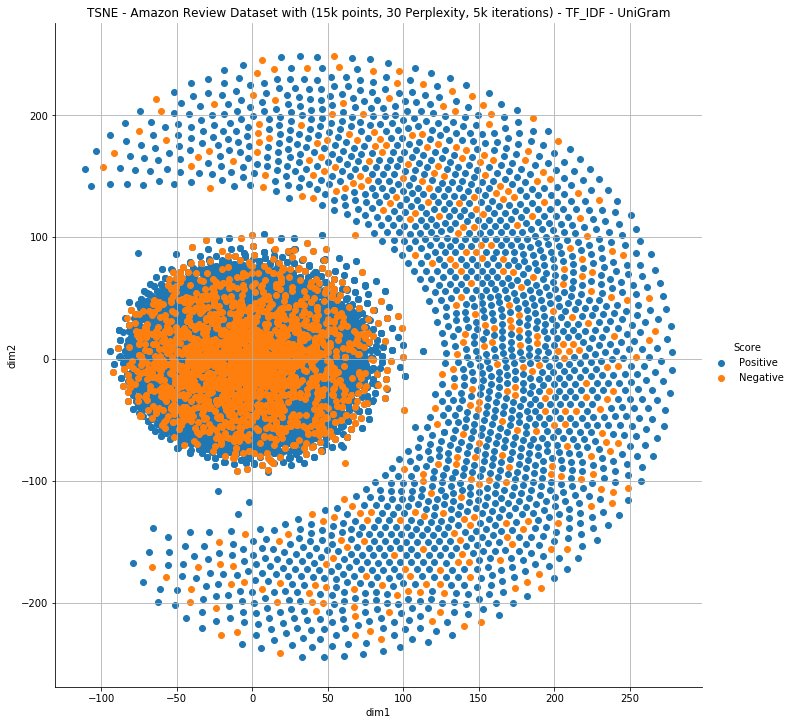

In [11]:
# TF-IDF
def tfidfUniGramMethod(df):
    print("Starting TF_IDF methods with shape : " + str(df.shape))
    global dictionary
    # TF_IDF Uni-Gram
    scores_df = df['Score']
    start_time = time.time()
    print('Starting TF_IDF UniGram')
    model = TfidfVectorizer()
    final_text = model.fit_transform(df['CleanedText'].values)
    print("The Shape of TF_IDF Model Uni-Gram : " + str(final_text.shape))
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    
    print('Converting the csr_matrix to ndarray')
    final_text = final_text.toarray().astype(float)
    print('Standardizing the data')
    final_text = StandardScaler().fit_transform(final_text)
    print('Starting the TSNE Model')
    tsne_data = TSNE(perplexity=30, n_iter=5000, n_components=2, random_state=0).fit_transform(final_text)
    final_df = pd.DataFrame(tsne_data, columns=['dim1', 'dim2'])
    final_df['Score'] = scores_df.values
    print('TSNE Model completed for TF_IDF-UniGram in '+ str(time.time() - start_time))

    plt.close()
    sns.FacetGrid(data=final_df, hue='Score', height=10).map(plt.scatter, "dim1", "dim2").add_legend()
    plt.title('TSNE - Amazon Review Dataset with (15k points, 30 Perplexity, 5k iterations) - TF_IDF - UniGram')
    plt.grid()
    plt.show()
    
    
tfidfUniGramMethod(final_df)

In [12]:
def returnListOfSentences(df):
    list_of_sentences = []
    for sent in df.values:
        list_of_sentences.append(sent.split())
    return list_of_sentences

start_time = time.time()
sentList = returnListOfSentences(final_df['CleanedText'])
print("Starting W2V Model..")
w2v_model = Word2Vec(sentList, size=100, min_count=4, workers=8)
w2v_words = list(w2v_model.wv.vocab)
print("Number of words that occured minimum 4 times ",len(w2v_words))
#print("sample words ", w2v_words[0:50])
print('W2V Model completed for in '+ str(time.time() - start_time))

Starting W2V Model..
Number of words that occured minimum 4 times  6824
W2V Model completed for in 4.378483533859253


In [13]:
def avgW2VcomputeModel(list_of_sent):
    # average Word2Vec
    # compute average word2vec for each review.
    start_time = time.time()
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sent): # for each review/sentence
        sent_vec = np.zeros(100) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    print('AvgW2V Model completed for in '+ str(time.time() - start_time))   
    return sent_vectors


print("Computing AvgWord2Vec Model..")    
sentVectors = avgW2VcomputeModel(sentList)

  1%|          | 142/15000 [00:00<00:10, 1404.58it/s]

Computing AvgWord2Vec Model..


100%|██████████| 15000/15000 [00:22<00:00, 654.65it/s]

AvgW2V Model completed for in 22.920954942703247


Converting to ndarray
Standardizing Array
Starting TSNE Model..
TSNE Model completed for AvgW2V in 2007.5378654003143


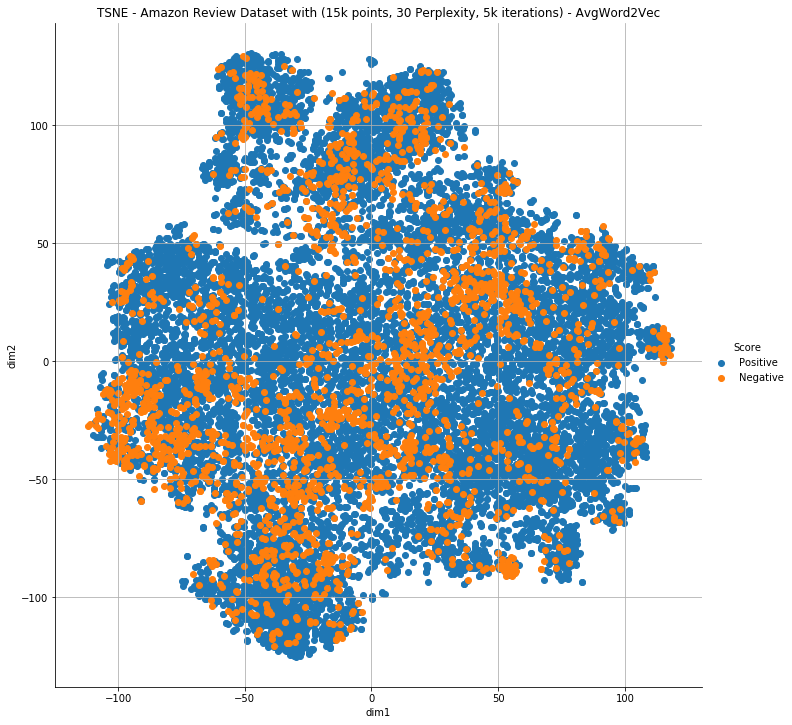

In [14]:
def plotTSNEModelForAvgW2V(sentVect, score_df):
    start_time = time.time()
    print("Converting to ndarray")
    arrayVec = np.array(sentVect, dtype=np.float64)
    print("Standardizing Array")
    standardizedVec = StandardScaler().fit_transform(arrayVec)
    print("Starting TSNE Model..")
    tsne_data = TSNE(perplexity=30, n_iter=5000, n_components=2, random_state=0).fit_transform(standardizedVec)
    final_df = pd.DataFrame(tsne_data, columns=['dim1', 'dim2'])
    final_df['Score'] = score_df.values
    print('TSNE Model completed for AvgW2V in '+ str(time.time() - start_time))
    
    plt.close()
    sns.FacetGrid(data=final_df, hue='Score', height=10).map(plt.scatter, "dim1", "dim2").add_legend()
    plt.title('TSNE - Amazon Review Dataset with (15k points, 30 Perplexity, 5k iterations) - AvgWord2Vec')
    plt.grid()
    plt.show()
    
    
plotTSNEModelForAvgW2V(sentVectors, final_df['Score'])

In [15]:
def tfidfW2VComputeModel(list_of_sent):
    # TF_IDF Word2Vec
    # compute TF_IDF word2vec for each review.
    start_time = time.time()
    
    tfidf_sent_vectors = []; # the tf-idf-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sent): # for each review/sentence
        sent_vec = np.zeros(100) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                if word in dictionary:
                    vec = w2v_model.wv[word]
                    tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                    sent_vec += (vec * tf_idf)
                    weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
    print('TF_IDFW2V Model completed for in '+ str(time.time() - start_time))   
    return tfidf_sent_vectors

print("Computing TF_IDFW2V Model..")
sentVectors = tfidfW2VComputeModel(sentList)

  1%|          | 107/15000 [00:00<00:14, 1049.89it/s]

Computing TF_IDFW2V Model..


100%|██████████| 15000/15000 [00:36<00:00, 415.22it/s]

TF_IDFW2V Model completed for in 36.130290031433105


Converting to ndarray
Standardizing Array
Starting TSNE Model..
TSNE Model completed for TF-IDFW2V in 2054.895176887512


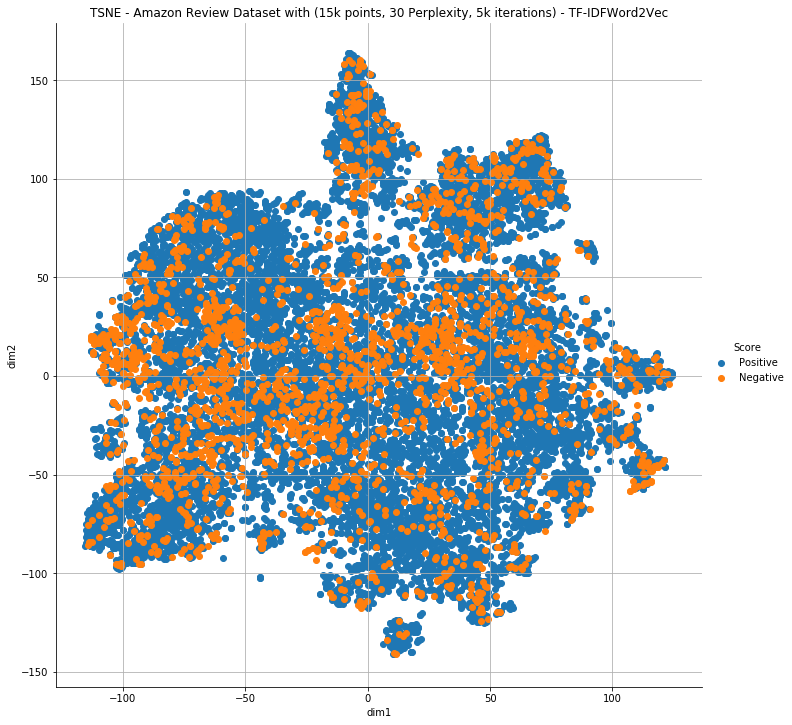

In [16]:
def plotTSNEModelForTFIDFW2V(sentVect, score_df):
    start_time = time.time()
    print("Converting to ndarray")
    arrayVec = np.array(sentVect, dtype=np.float64)
    print("Standardizing Array")
    standardizedVec = StandardScaler().fit_transform(arrayVec)
    print("Starting TSNE Model..")
    tsne_data = TSNE(perplexity=30, n_iter=5000, n_components=2, random_state=0).fit_transform(standardizedVec)
    final_df = pd.DataFrame(tsne_data, columns=['dim1', 'dim2'])
    final_df['Score'] = score_df.values
    print('TSNE Model completed for TF-IDFW2V in '+ str(time.time() - start_time))
    
    plt.close()
    sns.FacetGrid(data=final_df, hue='Score', height=10).map(plt.scatter, "dim1", "dim2").add_legend()
    plt.title('TSNE - Amazon Review Dataset with (15k points, 30 Perplexity, 5k iterations) - TF-IDFWord2Vec')
    plt.grid()
    plt.show()
    
    
plotTSNEModelForTFIDFW2V(sentVectors, final_df['Score'])

## Conclusion / Final thoughts -

1. Each of the plots above for BOW, TFIDF, BowAvgw2V and TFIDFW2v methods are highly overlapped.
2. None of the plots gives a well seperation between both positive/negative reviews.
3. We need to explore more using advance algorithms for better understanding or better differentiation for the classification.